In [1]:
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import pymc as pm
import seaborn as sns
import scipy.stats as stats
import arviz as az
from _fitting import *

from pymc.distributions.timeseries import EulerMaruyama


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Estimating the parameters of a stock evolving according to geometric Brownian motion

Here we want to estimate the parameters of a stock evolving according to geometric Brownian motion. In this case the stock price evolves according to
$$
dS_{t} = \mu S_{t} dt + \sigma S_{t} dW_{t}
$$

In [3]:
# Define the parameters
mu_t = 0.01
sigma_t = 0.1
S0 = 100
n = 1

params_guess = [mu_t, 0.1, sigma_t]

# Define the time period
dt = 0.01
t = np.arange(0, 20, dt)

ds = 0.1
s = np.arange(0.01, t[-1]*S0, ds)

# Calculate the stock price at time t
St = stockprice_evolution(S0, t, dt, mu_t, sigma_t, n)[0]
true_pdf = stock_pdf(s, S0, t[-1], mu_t, sigma_t)

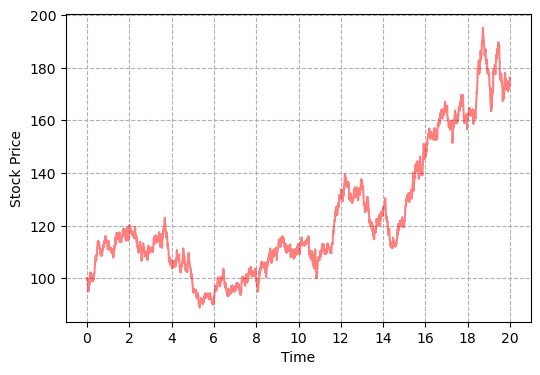

In [4]:
fig = plt.figure(figsize=(6, 4))
plt.plot(t, St.T, color='r', alpha=0.5)
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.grid(linestyle='--')
plt.xticks(np.arange(0, 22, 2))
plt.show()

# Using pymc to fit a model to data

Here we want to use pymc3 to estimate the parameters of the geometric brownian motion describing the evolution of a stock price.

# Making use of the marginal distribution

Now we want to compute the probability distribution over the future stock values given our distributions over $\mu$ and $\sigma$. This distribution is given by 
$$
P(s) = \int \int P(s|\mu,\sigma) P(\mu)P(\sigma) d\mu d\sigma
$$

In [5]:
# Use fitting function to fit the model

s_est, estimate_pdf = estimate_stock_distribution(St, params_guess, dt, 5, S0, ds=ds)

/Users/michael/miniconda3/lib/python3.10/site-packages/pymc/distributions/timeseries.py:973: UserWarning: Initial distribution not specified, defaulting to `Normal.dist(0, 100, shape=...)`. You can specify an init_dist manually to suppress this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, stock]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


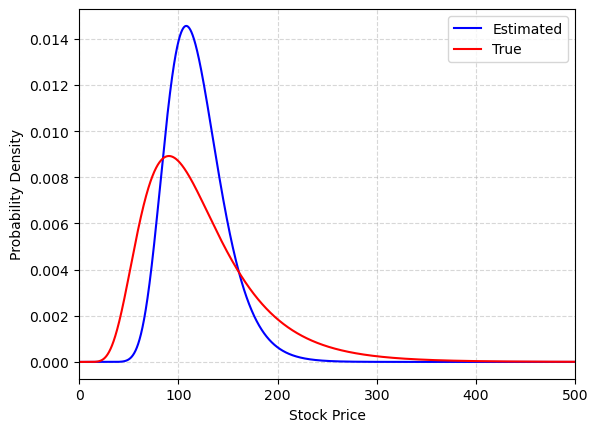

In [6]:
# Plot the estimated stock price distribution
plt.plot(s_est, estimate_pdf, color='b', label='Estimated')
plt.plot(s, true_pdf, color='r', label='True')
plt.xlabel("Stock Price")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(linestyle='--', alpha=0.5)

plt.xlim(0, 500)
plt.show()

# Now we want to ask the question, is this distribution useful for us to make decisions?

Because we are infering the underlying properties from the data, rather than the true underlying process, the two will naturally disagree. This isn't necessarily a bad thing, for example if the stock has gone up over a period of time, we would naturally infer that their is some driving force underlying this process. The question is, does this make sense? Are there fundamental reasons why these price changes are occuring? Or is it just noise? Even so, we can now set about constructing a betting strategy based on this distribution. 